<a href="https://colab.research.google.com/github/THESHADOW2030/tweetsDisaster/blob/main/bigDataProject_DisasterClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Configuration Stuff

In [1]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
!pip install pyspark
# Alternatively, if you want to install a specific version of pyspark:
#!pip install pyspark==3.2.1
!pip install -U -q PyDrive # To use files that are stored in Google Drive directly (e.g., without downloading them from an external URL)
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=99f2ce2f68063693dd622faa701e5ec633268b846e0c40dfb4883f4c6e585dbe
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 36.5 MB of archives.
After this operatio

###Some libraries that may be useful

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.ml.linalg import VectorUDT, Vectors

from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType

###Spark configuration

In [3]:
                         
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("PySparkTutorial").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [4]:
spark

In [5]:

sc._conf.getAll()

[('spark.app.name', 'PySparkTutorial'),
 ('spark.app.submitTime', '1685998473466'),
 ('spark.driver.memory', '45G'),
 ('spark.executor.id', 'driver'),
 ('spark.app.startTime', '1685998473715'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=jav

#Data Loading

In [6]:
from google.colab import drive
drive.mount('/content/drive')
#dataPath = "/content/drive/MyDrive/bigData/train.csv"
#%cd /content/drive/MyDrive/bigData/

Mounted at /content/drive


In [7]:
!wget https://raw.githubusercontent.com/THESHADOW2030/tweetsDisaster/main/train.csv
%ls

--2023-06-05 20:55:04--  https://raw.githubusercontent.com/THESHADOW2030/tweetsDisaster/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 987712 (965K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 964.56K  --.-KB/s    in 0.007s  

2023-06-05 20:55:04 (134 MB/s) - ‘train.csv’ saved [987712/987712]

drive/  sample_data/  train.csv


In [8]:
df = spark.read.load('./train.csv' , format="csv", inferSchema="true", header="true")


In [9]:
df.show(5, truncate=False)

+---+-------+--------+-------------------------------------------------------------------------------------------------------------------------------------+------+
|id |keyword|location|text                                                                                                                                 |target|
+---+-------+--------+-------------------------------------------------------------------------------------------------------------------------------------+------+
|1  |null   |null    |Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all                                                                |1     |
|4  |null   |null    |Forest fire near La Ronge Sask. Canada                                                                                               |1     |
|5  |null   |null    |All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected|1     |
|6  |null   |nul

In [10]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- keyword: string (nullable = true)
 |-- location: string (nullable = true)
 |-- text: string (nullable = true)
 |-- target: integer (nullable = true)



In [11]:
columnToDrop = ['keyword', 'location']
df = df.drop(*columnToDrop)

###Show 5 disaster tweets and 5 non disaster tweets

In [12]:
disTweets = df.filter(col("target") == 1)   #select only the rows that have target = 1
regTweets = df.filter(col("target") == 0)   #select only the rows that have target = 1



In [13]:
disTweets.show(5, truncate=False)
regTweets.show(5, truncate=False)

+---+-------------------------------------------------------------------------------------------------------------------------------------+------+
|id |text                                                                                                                                 |target|
+---+-------------------------------------------------------------------------------------------------------------------------------------+------+
|1  |Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all                                                                |1     |
|4  |Forest fire near La Ronge Sask. Canada                                                                                               |1     |
|5  |All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected|1     |
|6  |13,000 people receive #wildfires evacuation orders in California                                                 

There are 4095 tweets that are NOT abount a disaster before balancing
There are 3081 tweets about a disaster before balancing


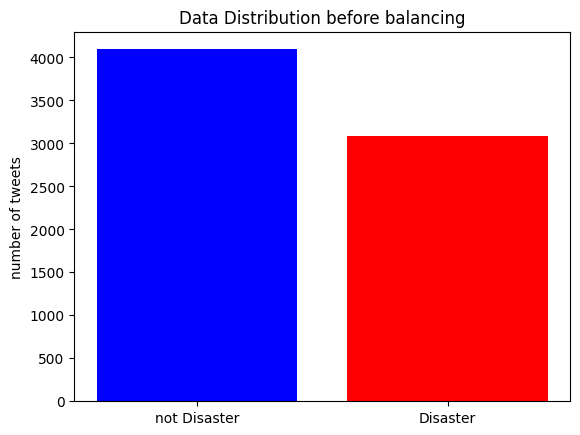

In [14]:
print(f"There are {regTweets.count()} tweets that are NOT abount a disaster before balancing")
print(f"There are {disTweets.count()} tweets about a disaster before balancing")
fig, ax = plt.subplots()
x = ['not Disaster', 'Disaster']
y = [regTweets.count(), disTweets.count()]
ax.bar(x, y, color=['blue', 'red'])
ax.set_ylabel('number of tweets')
ax.set_title('Data Distribution before balancing')
plt.show()

As we can see from these numbers, this is an unbalanced dataset. There are 32% more disaster tweets than the regular ones. In order to overcome this problem I'll use a technique called **Under Sampling**. It involves randomly removing instances from the majority class to match the number of instances in the minority class

In [15]:
regTweets = regTweets.select('*').orderBy(rand())
regTweets = regTweets.limit(disTweets.count())


There are 3081 tweets that are NOT abount a disaster after balancing
There are 3081 tweets about a disaster after balancing


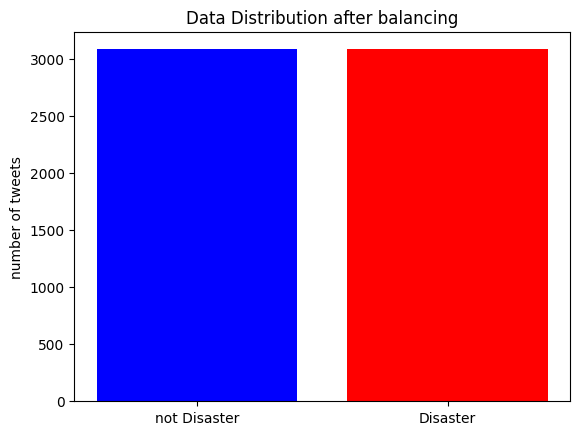

In [16]:
print(f"There are {regTweets.count()} tweets that are NOT abount a disaster after balancing")
print(f"There are {disTweets.count()} tweets about a disaster after balancing")
fig, ax = plt.subplots()
x = ['not Disaster', 'Disaster']
y = [disTweets.count(), regTweets.count()]
ax.bar(x, y, color=['blue', 'red'])
ax.set_ylabel('number of tweets')
ax.set_title('Data Distribution after balancing')
plt.show()

Let us unite them again

In [17]:
tweets = regTweets.union(disTweets)

#Data Preprocessing

In [18]:
def clean_text(df, column_name="text"):
    """ 
    This function takes the raw text data and apply a standard NLP preprocessing pipeline consisting of the following steps:
      - Text cleaning
      - Tokenization
      - Stopwords removal
      - Stemming (Snowball stemmer)

    parameter: dataframe
    returns: the input dataframe along with the `cleaned_content` column as the results of the NLP preprocessing pipeline

    """
    from pyspark.sql.functions import udf, col, lower, trim, regexp_replace
    from pyspark.ml.feature import Tokenizer, StopWordsRemover
    from nltk.stem.snowball import SnowballStemmer

    # Text preprocessing pipeline
    #print("***** Text Preprocessing Pipeline *****\n")

    # 1. Text cleaning
    #print("# 1. Text Cleaning\n")
    # 1.a Case normalization
    #print("1.a Case normalization:")
    lower_case_news_df = df.select("id", lower(col(column_name)).alias(column_name), "target")
    #lower_case_news_df.show(10)
    # 1.b Trimming
    #print("1.b Trimming:")
    trimmed_news_df = lower_case_news_df.select("id", trim(col(column_name)).alias(column_name), "target")
    #trimmed_news_df.show(10)
    # 1.c Filter out punctuation symbols
    #print("1.c Filter out punctuation:")
    no_punct_news_df = trimmed_news_df.select("id", (regexp_replace(col(column_name), "[^a-zA-Z\s]", "")).alias(column_name), "target")
    #no_punct_news_df.show(10)
    # 1.d Filter out any internal extra whitespace
    #print("1.d Filter out extra whitespaces:")
    cleaned_news_df = no_punct_news_df.select("id", trim(regexp_replace(col(column_name), " +", " ")).alias(column_name), "target")
    #cleaned_news_df.show(10)

    # 2. Tokenization (split text into tokens)
    #print("# 2. Tokenization:")
    tokenizer = Tokenizer(inputCol=column_name, outputCol="tokens")
    tokens_df = tokenizer.transform(cleaned_news_df)
    #tokens_df.show(10)

    # 3. Stopwords removal
    #print("# 3. Stopwords removal:")
    stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="terms")
    terms_df = stopwords_remover.transform(tokens_df)
    #terms_df.show(10)

    # 4. Stemming (Snowball stemmer)
    #print("# 4. Stemming:")
    stemmer = SnowballStemmer(language="english")
    stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
    terms_stemmed_df = terms_df.withColumn("terms_stemmed", stemmer_udf("terms"))
    #terms_stemmed_df.show(10)
    
    return terms_stemmed_df

In [19]:
tweets_preProcessed = clean_text(tweets)
columnToDrop = ['id', 'text', 'tokens', 'terms']
tweets_preProcessed = tweets_preProcessed.drop(*columnToDrop)
tweets_preProcessed.show(5, truncate = False)

+------+-------------------------------------------------------------------------------------------------------------------------+
|target|terms_stemmed                                                                                                            |
+------+-------------------------------------------------------------------------------------------------------------------------+
|0     |[tomorrow, announc, vod, httptcocubzemizm]                                                                               |
|0     |[roger, goodel, fatal, mistak, tom, bradi, innoc, man, httptcoucnckrnlow]                                                |
|0     |[flood, fish, final, sunshin, amp, fab, deal, albertson, anniversari, sale, lauren, paint, beauti, life, httptcocwhslmbx]|
|0     |[sink, last, episod, heart, hurt, bad]                                                                                   |
|0     |[potus, mayb, call, israel, tell, sorri, pres, sold, river, annihil]       

### Gensim
Gensim is a Python library used for topic modeling and natural language processing tasks, providing efficient algorithms for document similarity analysis, document clustering, and more.
It offers an easy-to-use interface and robust functionality for handling large text collections and extracting meaningful patterns and insights from them.

In [20]:
#@title Gensim Download
import gensim.downloader as api
import gensim
downloadModel = True
numberOfEmbeddings = 100 #25 50 100 200

In [21]:
#modelPath = './word2vec-google-news-300'
if downloadModel:
  wv = api.load(f"glove-twitter-{numberOfEmbeddings}")
  #wv.save(modelPath)
  downloadModel = False

[=================================================-] 99.7% 385.9/387.1MB downloaded


Below I have defined two User Defined Function. Each UDF will be applied to each row

In [22]:
# embeddingExtractor takes a list of tokens as input and returns a nested list of float values. 
#It checks if each token exists in the model. If found, it retrieves the corresponding vector. 
#If not found, it creates a list of zeros

embeddingExtractor = udf(lambda tokens: [[float(x) for x in wv[token]] if token in wv else [float(0.0)]*wv["king"].shape[0] for token in tokens], ArrayType((ArrayType(FloatType()))))


#Needed to do some pooling
avgEmbedding = udf(lambda x :[float(y) for y in np.mean(x, axis = 0)])

In [23]:
tweets_withEmbedding = tweets_preProcessed.withColumn("wordsEmbedding", embeddingExtractor("terms_stemmed"))
tweets_withEmbedding = tweets_withEmbedding.withColumn("tweetEmbedding", avgEmbedding("wordsEmbedding"))
tweets_withEmbedding.show(5, truncate = False)

+------+-------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Since pySpark does not support ArrayType((ArrayType(FloatType()))) for its model, I need to convert it in a Vector Type

In [24]:

#Define a UDF to convert the arrays of floats into dense vectors
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

#Apply the UDF to transform the "tweetEmbedding" column
tweets_withEmbedding = tweets_withEmbedding.withColumn("tweetEmbedding", array_to_vector_udf(tweets_withEmbedding["tweetEmbedding"]))

columnToDrop = ['wordsEmbedding']
tweets_withEmbedding = tweets_withEmbedding.drop(*columnToDrop)




In [25]:
#@title data visualizzation
tweets_withEmbedding.show(5, truncate = False)
for column_name, column_type in tweets_withEmbedding.dtypes:
    print(f"Column '{column_name}' has data type: {column_type}")

+------+-------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [26]:
#@title test-train split
train_df, test_df = tweets_withEmbedding.randomSplit([0.8, 0.2], seed = 42)
print(train_df.count())
print(test_df.count())


4999
1163


#Fun Part
Here comes the fun part. In this section, will perform some tecquiniques in order to visualize better the data (using PCA in order to plot it) and machine learning algortithms (SVC, Logistic Regression and many more)

##PCA

In [27]:
from pyspark.ml.feature import PCA, StandardScaler

# Normalize the input data
scaler = StandardScaler(inputCol="tweetEmbedding", outputCol="scaledFeatures")  #PCA is very sensitive to the scale of the input data, so we need to scale the data before applying PCA
scaled_data = scaler.fit(tweets_withEmbedding).transform(tweets_withEmbedding)

K = 10          # number of principal components
pca_model = PCA(k=K, inputCol="scaledFeatures", outputCol="pca_features")
pca_features = pca_model.fit(scaled_data)
pca_tweets_df = pca_features.transform(scaled_data).cache()

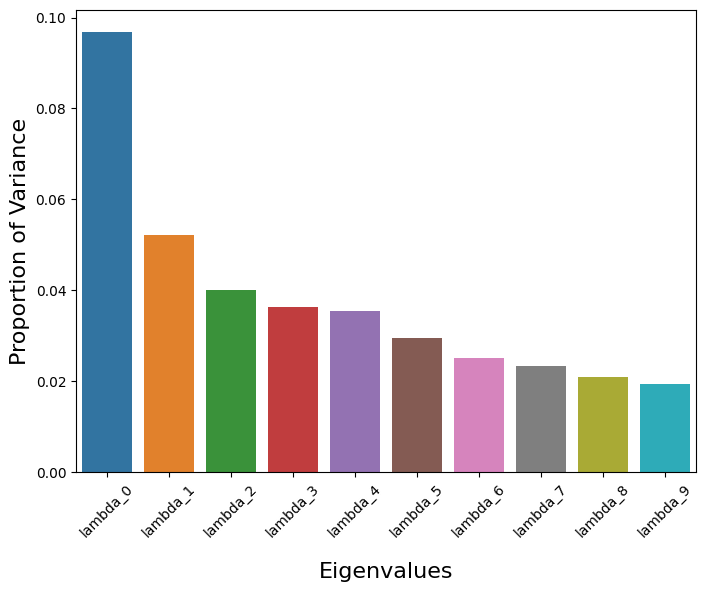

In [28]:
#@title Variance distribution
fig, ax = plt.subplots(1,1,figsize=(8,6))
_ = sns.barplot(x=[i for i in range(K)], 
                y=pca_features.explainedVariance.values, # `explainedVariance` returns the distribution of variance across eigenvectors, i.e., lambda_i/sum lambda_i
                ax=ax)
_ = ax.set_xlabel("Eigenvalues", labelpad=16, fontsize=16)
_ = ax.set_ylabel("Proportion of Variance", fontsize=16)
_ = ax.set_xticklabels(["lambda_{:d}".format(i) for i in range(K)], rotation=45)

Above we can see the variance of each component

In [29]:
#@title from pySpark dataframe to pandas dataframe
pca_tweets_pdf = pca_tweets_df.toPandas()

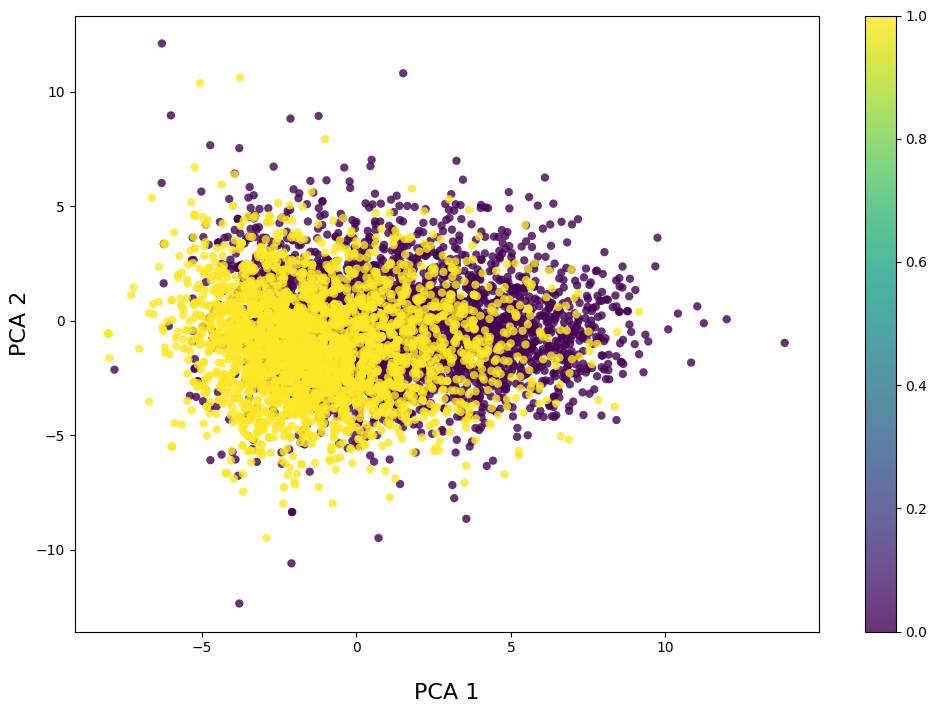

In [30]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
_ = plt.scatter(
    pca_tweets_pdf.pca_features.map(lambda x: x[0]), 
    pca_tweets_pdf.pca_features.map(lambda x: x[1]),
    c=pca_tweets_pdf.target, 
    edgecolor='none', 
    alpha=0.8,
    axes=ax
    )
_ = ax.set_xlabel('PCA 1', labelpad=20, fontsize = 16)
_ = ax.set_ylabel('PCA 2', fontsize = 16)
plt.colorbar()

##Machine Learning

Now that we visualized the data and did some exploration, we can try to capture some patterns by applying machine learning techniques.


Lets take a look again at our dataframe

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.metrics import classification_report
evaluator = BinaryClassificationEvaluator(labelCol="target", rawPredictionCol="prediction")
cols = ['target', 'prediction']


In [ ]:
def plotConfusionMatrix(preds, name = ""):
  cm = confusion_matrix(preds['target'], preds['prediction'])


  # Create a heatmap of the confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

  plt.title(f'Confusion Matrix {name}')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')

  plt.show()

There are 2517 tweets that are NOT abount a disaster
There are 2482 tweets about a disaster


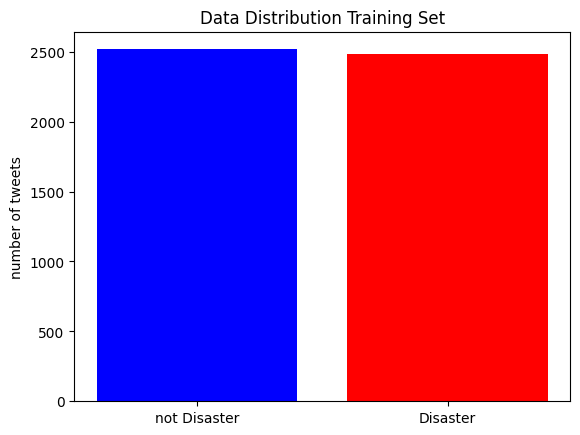

In [ ]:
#@title Distribution of the training examples
#df.filter(col("target") == 0)
nRegTrain = train_df.filter(col("target") == 0).count()
nDisTrain = train_df.filter(col("target") == 1).count()

print(f"There are {nRegTrain} tweets that are NOT abount a disaster")
print(f"There are {nDisTrain} tweets about a disaster")
fig, ax = plt.subplots()
x = ['not Disaster', 'Disaster']
y = [nRegTrain, nDisTrain]
ax.bar(x, y, color=['blue', 'red'])
ax.set_ylabel('number of tweets')
ax.set_title('Data Distribution Training Set')
plt.show()

There are 2517 tweets that are NOT abount a disaster
There are 2482 tweets about a disaster


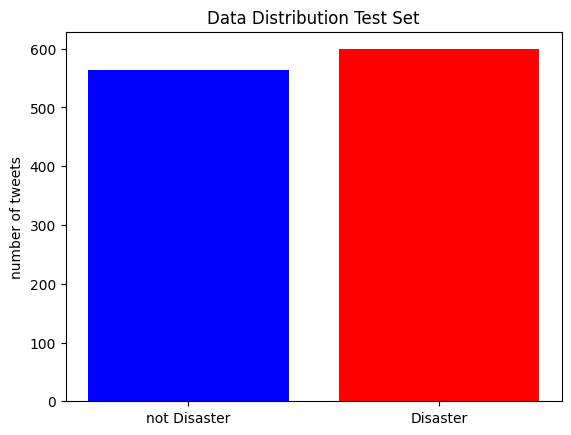

In [ ]:
#@title Distribution of the set examples
nRegTest = test_df.filter(col("target") == 0).count()
nDisTest = test_df.filter(col("target") == 1).count()

print(f"There are {nRegTrain} tweets that are NOT abount a disaster")
print(f"There are {nDisTrain} tweets about a disaster")
fig, ax = plt.subplots()
x = ['not Disaster', 'Disaster']
y = [nRegTest, nDisTest]
ax.bar(x, y, color=['blue', 'red'])
ax.set_ylabel('number of tweets')
ax.set_title('Data Distribution Test Set')
plt.show()

Great! Now that we have split the dataset in two sets: 
1.   Train set
2.   Test Set

Note: usually, I would create also a third split: the validation set. I didn't do it this time given the limited size of this dataset.



###Support Vector Classifier

SVC is a supervised machine learning algorithm. It is based on the idea that the algorithm creates a line or a hyperplane which separates the data into classes while maximizing the margin. The margin is the distance between the sepearation line and the closest points of each class. The points that are closest to the line are called support vectors.

In [ ]:
from pyspark.ml.classification import LinearSVC
linSVC = LinearSVC(featuresCol = "tweetEmbedding", labelCol = "target", maxIter=1000)
linSVC_model = linSVC.fit(train_df)

In [ ]:
# Get the training summary
summary = linSVC_model.summary()
print(summary.accuracy) #0.77

0.7743548709741949


In [ ]:
linSVC_pred = linSVC_model.transform(test_df)
print(evaluator.evaluate(linSVC_pred))

linSVC_pred_pd = linSVC_pred.select(*cols).toPandas()
report = classification_report(linSVC_pred_pd['target'], linSVC_pred_pd['prediction'])
print(report)


0.7639757160278953
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       564
           1       0.78      0.75      0.77       599

    accuracy                           0.76      1163
   macro avg       0.76      0.76      0.76      1163
weighted avg       0.76      0.76      0.76      1163



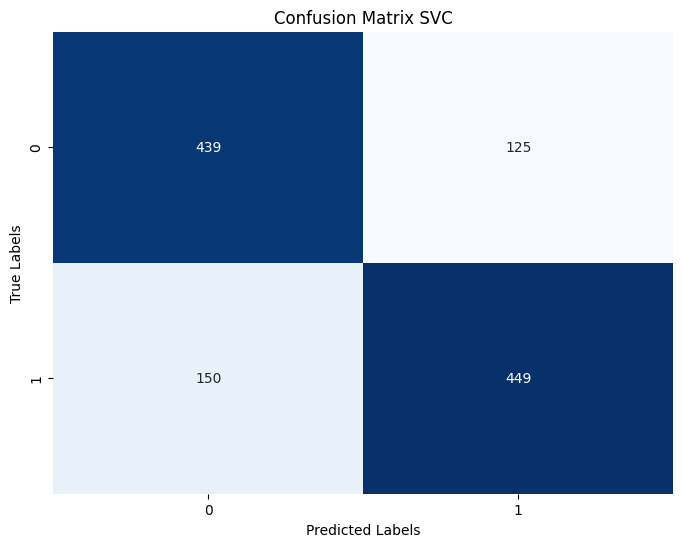

In [ ]:
plotConfusionMatrix(linSVC_pred_pd, name = "SVC")

###Multi Layer Perceptron

A Multi Layer Perceptron is the simpliest type of neural network and it's also the only type of neural network that is supported by Spark. 

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

mlp = MultilayerPerceptronClassifier( layers=[100, 50, 10, 2], seed=42, 
                                      featuresCol = "tweetEmbedding", labelCol = "target",
                                      maxIter = 100, 
                                     stepSize = 1e-3)

mlp_model = mlp.fit(train_df)
mlp_model.summary().accuracy

0.8159631926385277

In [ ]:
mlp_pred = mlp_model.transform(test_df)
evaluator.evaluate(mlp_pred)

mlp_pred_pd = mlp_pred.select(*cols).toPandas()
report = classification_report(mlp_pred_pd['target'], mlp_pred_pd['prediction'])
print(report)

              precision    recall  f1-score   support

           0       0.73      0.81      0.77       564
           1       0.80      0.72      0.76       599

    accuracy                           0.76      1163
   macro avg       0.77      0.76      0.76      1163
weighted avg       0.77      0.76      0.76      1163



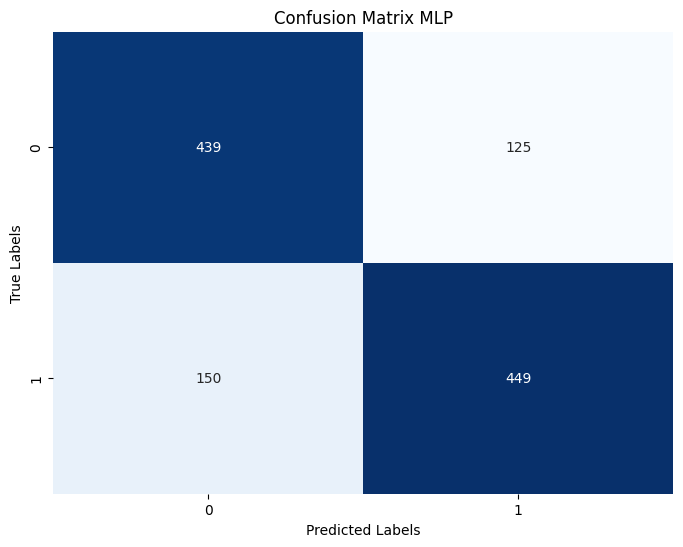

In [ ]:
plotConfusionMatrix(linSVC_pred_pd, name = "MLP")

###Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

alberello =  DecisionTreeClassifier( featuresCol = "tweetEmbedding", labelCol = "target")
decisionTree_model = alberello.fit(train_df)

In [ ]:
decisionTree_pred = decisionTree_model.transform(test_df)
print(evaluator.evaluate(decisionTree_pred))

decisionTree_pred_pd = decisionTree_pred.select(*cols).toPandas()
report = classification_report(decisionTree_pred_pd['target'], decisionTree_pred_pd['prediction'])
print(report)

0.7225562107057862
              precision    recall  f1-score   support

           0       0.69      0.76      0.73       564
           1       0.75      0.68      0.72       599

    accuracy                           0.72      1163
   macro avg       0.72      0.72      0.72      1163
weighted avg       0.72      0.72      0.72      1163



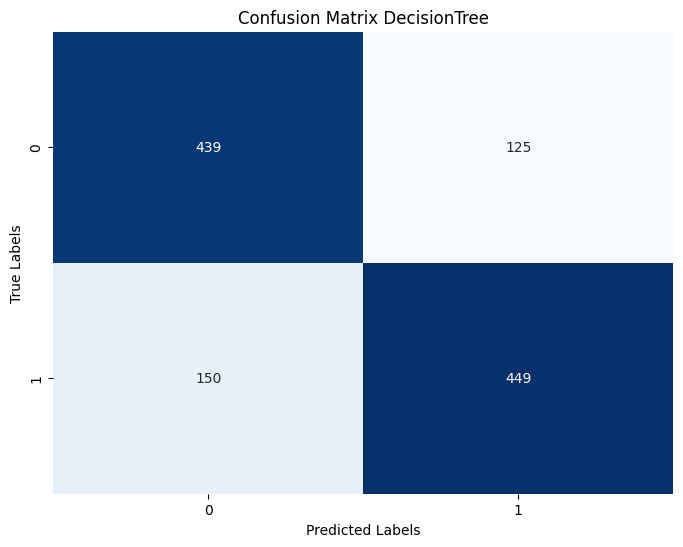

In [ ]:
plotConfusionMatrix(linSVC_pred_pd, name = "DecisionTree")

###Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

randomForest =  RandomForestClassifier( featuresCol = "tweetEmbedding", labelCol = "target")
randomForest_model = randomForest.fit(train_df)

In [ ]:
randomForest_pred = randomForest_model.transform(test_df)
print(evaluator.evaluate(randomForest_pred))

randomForest_pred_pd = randomForest_pred.select(*cols).toPandas()
report = classification_report(randomForest_pred_pd['target'], randomForest_pred_pd['prediction'])
print(report)

0.7638203151825146
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       564
           1       0.78      0.75      0.77       599

    accuracy                           0.76      1163
   macro avg       0.76      0.76      0.76      1163
weighted avg       0.76      0.76      0.76      1163



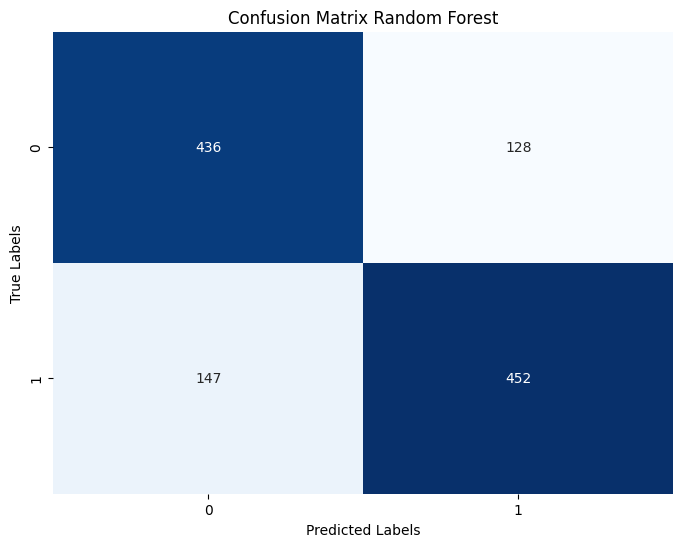

In [ ]:
plotConfusionMatrix(randomForest_pred_pd, name = "Random Forest")

###Gradient Boost Tree

In [ ]:
from pyspark.ml.classification import GBTClassifier

GBT =  GBTClassifier( featuresCol = "tweetEmbedding", labelCol = "target")
GBT_model = GBT.fit(train_df)

In [ ]:
GBT_pred = GBT_model.transform(test_df)
print(evaluator.evaluate(GBT_pred))

GBT_pd = GBT_pred.select(*cols).toPandas()
report = classification_report(GBT_pd['target'], GBT_pd['prediction'])
print(report)

0.7430617222557692
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       564
           1       0.76      0.74      0.75       599

    accuracy                           0.74      1163
   macro avg       0.74      0.74      0.74      1163
weighted avg       0.74      0.74      0.74      1163



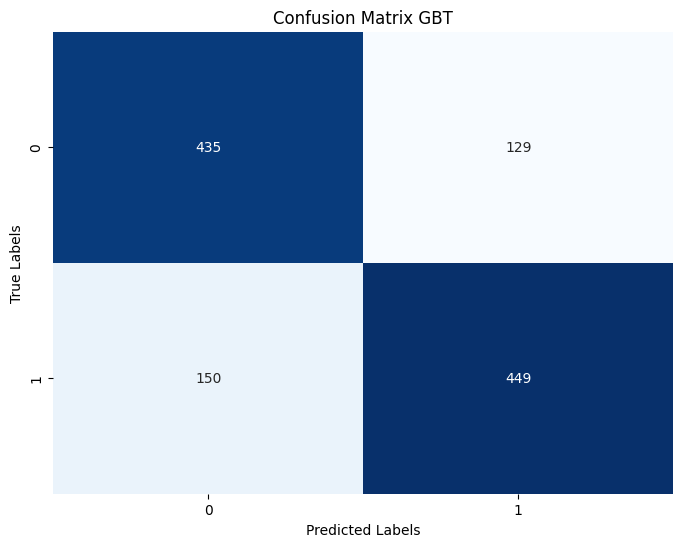

In [ ]:
plotConfusionMatrix(randomForest_pred_pd, name = "GBT")

###Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression

logReg =  LogisticRegression( featuresCol = "tweetEmbedding", labelCol = "target",
                              maxIter = 1000)

pipeline = Pipeline(stages = [logReg])
paramGrid = ParamGridBuilder().addGrid(logReg.regParam, [0.01, 0.1, 1.0]).addGrid(logReg.maxIter, [10, 100, 1000]).build()
crossVal = CrossValidator(estimator=pipeline, estimatorParamMaps = paramGrid, evaluator=evaluator, numFolds=5)
cvModel = crossVal.fit(train_df)
logReg_bestModel = cvModel.bestModel





In [ ]:
logReg_pred = logReg_bestModel.transform(test_df)
evaluator.evaluate(logReg_pred)


logReg_pred_pd = logReg_pred.select(*cols).toPandas()
report = classification_report(logReg_pred_pd['target'], logReg_pred_pd['prediction'])
print(report)

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       564
           1       0.80      0.77      0.79       599

    accuracy                           0.78      1163
   macro avg       0.78      0.78      0.78      1163
weighted avg       0.78      0.78      0.78      1163



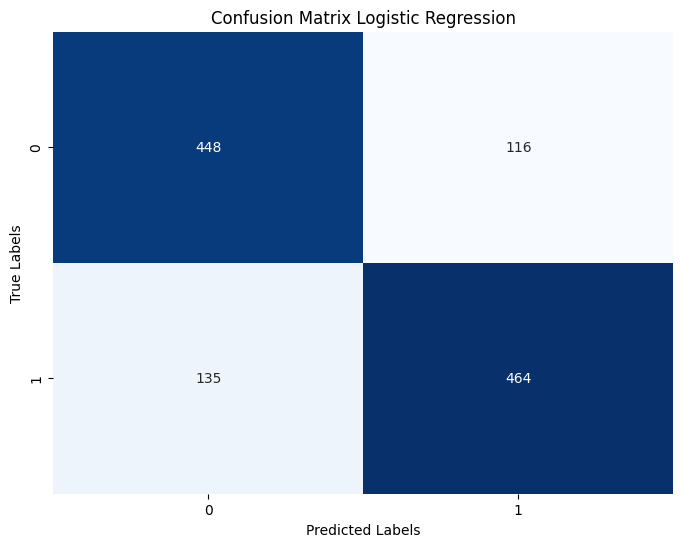

In [ ]:
plotConfusionMatrix(logReg_pred_pd, name = "Logistic Regression")

#A Powerful Model

From now on, I'll abandon pySpark in order to use some more advanced models

##Preliminary Stuff

In [ ]:
train_pandas = train_df.toPandas()
test_pands = test_df.toPandas()

In [ ]:
%cd '/content/drive/MyDrive/bigData/'
%ls

In [ ]:
train_pandas.to_csv("./train.csv")
test_pands.to_csv("./test.csv")

##Keras Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow  as  tf
from  tensorflow  import  keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn

import numpy as  np
import matplotlib.pyplot  as  plt
import os
import random

import pandas  as  pd
import tqdm as tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#print the number of GPU

print ( "Num GPUs Available: " ,  len ( tf.config.experimental.list_physical_devices ( 'GPU' )))

#import  the confusion matrix
from sklearn.metrics import confusion_matrix

!pip install pickle5
import pickle5 as pickle

Num GPUs Available:  1


/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd '/content/drive/MyDrive/bigData/'
%ls

train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
train_df['tweetEmbedding'] = train_df['tweetEmbedding'].str.strip('[]').str.split(',').apply(lambda x: [np.float64(num) for num in x]).to_numpy()
test_df['tweetEmbedding'] = test_df['tweetEmbedding'].str.strip('[]').str.split(',').apply(lambda x: [np.float64(num) for num in x]).to_numpy()
train_df.head()

/content/drive/MyDrive/bigData
disasterModel.h5  metadata/  test.csv       train.csv    train.csv.2
logRegModel/      stages/    tokenizer.pkl  train.csv.1  trainRaw.csv


,Unnamed: 0,target,terms_stemmed,tweetEmbedding
0,0,0,"['aannnnd', 'reddit', 'quarantin', 'offens', '...","[0.11176500717798869, -0.06851166486740112, -0..."
1,1,0,"['abcnew', 'uk', 'scandal', 'caus', 'major', '...","[-0.006568083539605141, 0.07620916950205962, 0..."
2,2,0,"['ablaz', 'lord', 'd']","[0.036786665519078575, 0.33721333742141724, 0...."
3,3,0,"['ablaz', 'time', 'talk', 'go', 'dont', 'know'...","[-0.11921422473258442, 0.24078921994401348, 0...."
4,4,0,"['absolut', 'demolish', 'sounder', 'start', 'f...","[-0.3361960083246231, 0.1496007923502475, 0.25..."


In [ ]:
#@title Function for correcting the stemmed list
def fixStemmed(df):

  newCol = []
  for index, row in df.iterrows():
    terms_stemmed = row['terms_stemmed'].strip('[]').split(',')
    newRow = []
    #print(terms_stemmed[0])
    for word in terms_stemmed:
      newRow.append(word.replace("'", "").replace(" ", ""))
    newCol.append(newRow)

  df["stemmed_list"] = newCol

  df.head()



In [ ]:
fixStemmed(train_df)
fixStemmed(test_df)

In [ ]:
texts = train_df["stemmed_list"].to_list()


###LSTM

In [ ]:
corpus = train_df['stemmed_list'].to_list() + test_df['stemmed_list'].to_list()


tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(corpus)


train_sequences = tokenizer.texts_to_sequences(train_df['stemmed_list'].to_list())
test_sequences = tokenizer.texts_to_sequences(test_df['stemmed_list'].to_list())


max_sequence_length = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))
train_data = keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_sequence_length)
test_data = keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_sequence_length)



In [ ]:
print(f"There are {len(tokenizer.word_index)} unique tokens")
print(f"The max sequence lenght is {max_sequence_length}")

There are 15515 unique tokens
The max sequence lenght is 23


In [ ]:
if False:
  tokenizer_path = "./tokenizer.pkl"
  with open(tokenizer_path, 'wb') as f:
      pickle.dump(tokenizer, f)

Here I model an LSTM. I've also considered using an bi-LSTM since "we can see in the future" but there weren't any significant improvements in this taks. I think that the main reason is that the dataset is too small 

In [ ]:
model = keras.models.Sequential()


model.add(layers.Embedding(len(tokenizer.word_index) + 1, 300, input_length=max_sequence_length))

model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(16, recurrent_dropout=0.2))


model.add(layers.Dense(4, activation='sigmoid'))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 300)           4654800   
                                                                 
 spatial_dropout1d (SpatialD  (None, 23, 300)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 16)                20288     
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 4,675,161
Trainable params: 4,675,161
Non-trainable params: 0
______________________________________________

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(train_data, np.array(train_df['target'].to_list()), epochs=2, batch_size=32, validation_data=(test_data, np.array(test_df['target'].to_list())))


Epoch 1/2
157/157 [==============================] - 41s 199ms/step - loss: 0.6049 - accuracy: 0.6765 - val_loss: 0.4873 - val_accuracy: 0.7911
Epoch 2/2
157/157 [==============================] - 18s 118ms/step - loss: 0.3665 - accuracy: 0.8772 - val_loss: 0.5048 - val_accuracy: 0.7807


In [ ]:
# Step 7: Evaluate the model
loss, accuracy = model.evaluate(test_data, np.array(test_df['target'].to_list()))
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

#classification report
"""
decisionTree_pred_pd = decisionTree_pred.select(*cols).toPandas()
report = classification_report(decisionTree_pred_pd['target'], decisionTree_pred_pd['prediction'])
print(report)
"""



print(classification_report(np.array(test_df['target'].to_list()), np.array([np.round(x) for x in model.predict(test_data)])))

37/37 [==============================] - 1s 13ms/step - loss: 0.5048 - accuracy: 0.7807
Test Loss: 0.5048418045043945
Test Accuracy: 0.7807394862174988
37/37 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.78      0.77      0.77       564
           1       0.78      0.79      0.79       599

    accuracy                           0.78      1163
   macro avg       0.78      0.78      0.78      1163
weighted avg       0.78      0.78      0.78      1163



In [ ]:
saveModel = False

if saveModel:
  model.save("./disasterModel.h5")